In [1]:
import get_data as get_data
import load_data as load
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
from keras import backend as K 

import time
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

WINDOW = 22


Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
data = pd.read_csv('./data_research/recount_data.csv')

In [4]:
data.columns


Index(['exchange', 'pair', 'model', 'prediction_close', 'prediction_trend',
       'prediction_percentage_trend', 'date', 'real_close', 'real_trend',
       'real_percentage_trend', 'close_diff', 'trend_diff',
       'trend_percentage_diff', 'percentage_diff',
       'prediction_close_on_precentage'],
      dtype='object')

In [12]:
frame = data[['date', 'prediction_close', 'real_close','prediction_trend','real_trend',
       'prediction_percentage_trend',  
       'real_percentage_trend' ]]

In [13]:
frame

,date,prediction_close,real_close,prediction_trend,real_trend,prediction_percentage_trend,real_percentage_trend
0,2017-08-07,2813.034912,NaN,100.770996,NaN,3.715383,NaN
1,2017-08-06,2712.263916,3229.000000,105.269043,-27.536656,4.037946,-0.845581
2,2017-08-05,2606.994873,3256.536656,-14.516357,393.526657,-0.553740,13.745207
3,2017-08-04,2621.511230,2863.009999,-13.585693,68.119999,-0.515567,2.437305
4,2017-08-03,2635.096924,2794.890000,-16.734131,95.890000,-0.631041,3.552797
5,2017-08-02,2651.831055,2699.000000,-13.101562,-37.482685,-0.491628,-1.369740
6,2017-08-01,2664.932617,2736.482685,8.259277,-118.517315,0.310888,-4.151219
7,2017-07-31,2656.673340,2855.000000,19.948975,102.000000,0.756582,3.705049
8,2017-07-30,2636.724365,2753.000000,26.781494,34.000000,1.026133,1.250460
9,2017-07-29,2609.942871,2719.000000,10.716064,-70.981200,0.412279,-2.544146


In [59]:
K = (frame.real_close.shift(-1) / frame.prediction_close.shift(-1)) # K

perc_K = K * frame.prediction_percentage_trend / 100

predicition = perc_K * frame.real_close.shift(-1) + frame.real_close.shift(-1)

frame['pred_scaled'] = predicition

a = frame[['date', 'prediction_close', 'real_close', 'pred_scaled']]

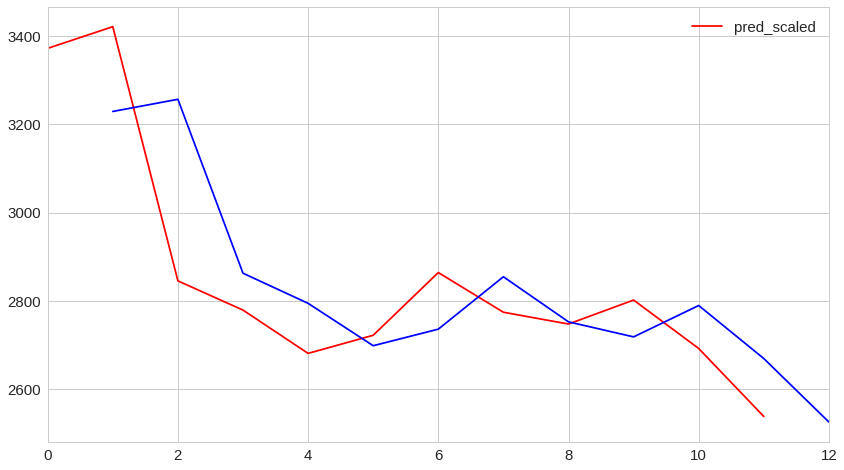

In [56]:
frame[['pred_scaled']].plot(color = 'red')
frame['real_close'].plot(color = 'blue')
plt.show()

In [68]:
frame[['prediction_close', 'real_close']]

,prediction_close,real_close
0,2813.034912,NaN
1,2712.263916,3229.000000
2,2606.994873,3256.536656
3,2621.511230,2863.009999
4,2635.096924,2794.890000
5,2651.831055,2699.000000
6,2664.932617,2736.482685
7,2656.673340,2855.000000
8,2636.724365,2753.000000
9,2609.942871,2719.000000


In [91]:
percentage_real_close = (frame.real_close - frame.real_close[frame.last_valid_index()]) \
                            / frame.real_close[frame.last_valid_index()]

In [92]:
percentage_pred_close = (frame.prediction_close - frame.prediction_close[frame.last_valid_index()]) \
                            / frame.prediction_close[frame.last_valid_index()]

In [93]:
percentage_pred_close

0     0.096656
1     0.057370
2     0.016331
3     0.021991
4     0.027287
5     0.033811
6     0.038918
7     0.035698
8     0.027921
9     0.017481
10    0.013303
11    0.005040
12    0.000000
Name: prediction_close, dtype: float64

In [102]:
z = pd.DataFrame()
z['percentage_real_close' ] =percentage_real_close
z['percentage_pred_close'] = percentage_pred_close

In [104]:
z['div_perc'] = z.percentage_real_close/z.percentage_pred_close

In [109]:
np.sum(np.abs(z.div_perc))/(z.shape[0]-1)

5.583820063998267

In [128]:
z['new_close_perc'] = z.percentage_pred_close * np.min(z.div_perc)

In [129]:
z['new_close'] = z['new_close_perc'] * frame.prediction_close[frame.last_valid_index()] +  frame.prediction_close

In [130]:
z['real_close'] = frame.real_close

In [131]:
z

,percentage_real_close,percentage_pred_close,div_perc,new_close,new_close_perc,real_close
0,NaN,0.096656,NaN,3314.164321,0.195364,NaN
1,0.278128,0.057370,4.847951,3009.710933,0.115959,3229.000000
2,0.289028,0.016331,17.697738,2691.667864,0.033010,3256.536656
3,0.133259,0.021991,6.059845,2735.525267,0.044448,2863.009999
4,0.106295,0.027287,3.895476,2776.570911,0.055153,2794.890000
5,0.068339,0.033811,2.021240,2827.128740,0.068339,2699.000000
6,0.083176,0.038918,2.137201,2866.711708,0.078663,2736.482685
7,0.130089,0.035698,3.644102,2841.758447,0.072155,2855.000000
8,0.089714,0.027921,3.213104,2781.487802,0.056436,2753.000000
9,0.076256,0.017481,4.362315,2700.574474,0.035333,2719.000000


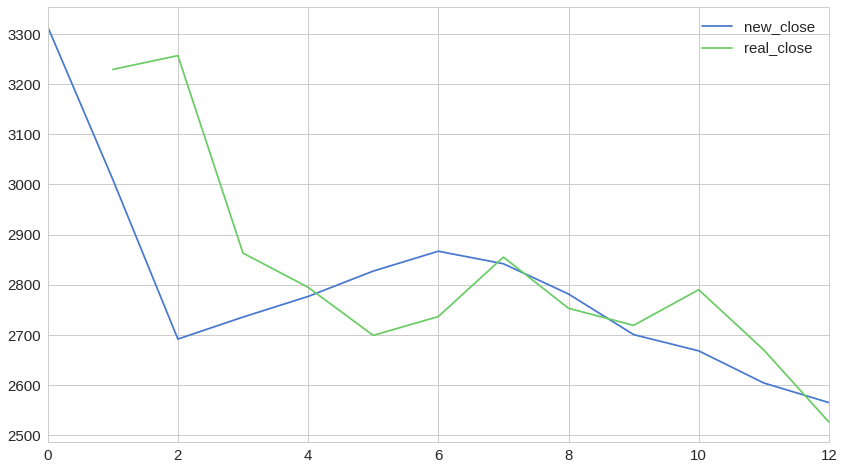

In [133]:
z[['new_close', 'real_close']].plot()